In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Load and transform images

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True,  download=True, transform=transform)
test_set  = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(
    test_set,  batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified


In [5]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

In [6]:
# random imgs
data_iter = iter(train_loader)
images, labels = data_iter.next()

Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/

horse  deer   dog plane


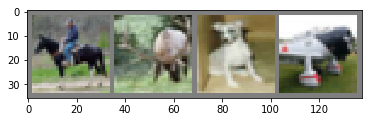

In [7]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[i]] for i in range(4)))

# Define Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # ch_in, ch_out, conv_kern
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
net = Net()

# Loss function and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train

In [14]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.4f' 
                  % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.
            
print('Training completed.')

[1,  2000] loss: 1.5738
[1,  4000] loss: 1.5295
[1,  6000] loss: 1.4628
[1,  8000] loss: 1.4265
[1, 10000] loss: 1.4276
[1, 12000] loss: 1.3785
[2,  2000] loss: 1.3214
[2,  4000] loss: 1.2908
[2,  6000] loss: 1.2878
[2,  8000] loss: 1.2759
[2, 10000] loss: 1.2509
[2, 12000] loss: 1.2754
Training completed.


Ground Truth:    cat  ship  ship plane


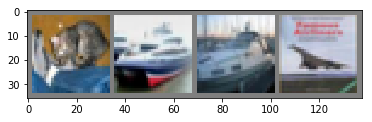

In [17]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', 
      ' '.join('%5s' % classes[labels[i]] for i in range(4)))

In [18]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', 
      ' '.join('%5s' % classes[predicted[i]] for i in range(4)))

Predicted:    cat  ship  ship plane


# Evaluate

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on 1000 test images: %d%%' % (100 * correct / total))

Accuracy on 1000 test images: 54%


In [22]:
# Asses errors
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s: %2d%%' 
          % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 75%
Accuracy of   car: 79%
Accuracy of  bird: 41%
Accuracy of   cat: 37%
Accuracy of  deer: 38%
Accuracy of   dog: 46%
Accuracy of  frog: 60%
Accuracy of horse: 59%
Accuracy of  ship: 59%
Accuracy of truck: 43%


# Training on GPU

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# if cuda:
net.to(device)
inputs, labels = inputs.to(decice), labels.to(device)